# Neural Style Transfer Implementation

## Imports

In [1]:
import torch
import torch.optim as optim
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
from fastprogress.fastprogress import progress_bar

import os
import wget

model_file = './vgg19.pth'

if not os.path.exists(model_file):
    wget.download("https://web.eecs.umich.edu/~justincj/models/vgg19-d01eb7cb.pth", model_file)

## Image Utils

In [2]:
def show_image(image, title=''):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.array(image / 255).clip(0, 1)
    plt.figure(figsize=(8, 4))
    plt.title(title)
    plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.imshow(image)
    plt.show()

normalizer = ([103.939, 116.779, 123.68], [1, 1, 1])

def image_to_tensor(image):
    transformation = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])
    return transforms.Normalize(*normalizer)(transformation(image) * 255).unsqueeze(dim=0)

def tensor_to_image(tensor):
    transformation = transforms.Compose([transforms.Normalize([-i for i in normalizer[0]], normalizer[1])])
    return transformation(tensor.squeeze()).numpy().transpose(1, 2, 0)

## Model Forward

In [3]:
def forward(model, tensor):
    layers = {
        '3': 'relu1_2',  
        '8': 'relu2_2',
        '17': 'relu3_3',
        '24': 'relu4_2',
        '26': 'relu4_3',
        '35': 'relu5_3',
    }

    features = {}
    x = tensor

    for name, layer in model._modules.items():
        x = layer(x)

        if name in layers:
            if name == '24' or name == '31':   
                features[layers[name]] = x
            else:
                _, c, h, w = x.shape
                tensor = x.view(c, h * w)
                features[layers[name]] = torch.mm(tensor, tensor.t()) / (h * w)

            if name == '35':
                break

    return features

## Transfer style

In [4]:
mse_loss = torch.nn.MSELoss()

def transfer_style(
    model,
    optimizer,
    content_tensor,
    style_tensor,
    iterations,
    show_iterations=1000,
    alpha=1e-7,
    beta=1e-5,
):
    content_layers = ['relu4_2']
    content_weights = {'relu4_2': 1}
    style_layers = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3']
    style_weights = dict((i, 0.2) for i in style_layers)
    content = forward(model, content_tensor)
    style = forward(model, style_tensor)

    for i in progress_bar(range(iterations)):
        def step():
            optimizer.zero_grad()

            gram = forward(model, g)
            c_loss, s_loss = 0, 0

            for j in content_layers:
                c_loss += content_weights[j] * mse_loss(gram[j], content[j])

            for j in style_layers:
                gram_j = gram[j]
                style_loss = mse_loss(gram_j, style[j]) / (gram_j.shape[0] ** 2)
                s_loss += style_weights[j] * style_loss
            
            total_loss = alpha * c_loss + beta * s_loss
            total_loss.backward(retain_graph=True)

            if i % show_iterations == 0:
                show_image(tensor_to_image(g.clone().detach()), f'iteration {i}/{iterations}')
                plt.show()

            return total_loss
        optimizer.step(step)

    return g

## Running

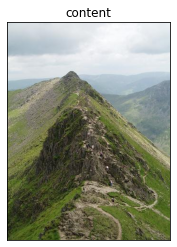

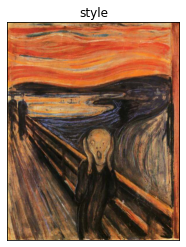

In [5]:
vgg = models.vgg19(pretrained = False)
vgg.load_state_dict(torch.load(model_file), strict=False)
model = vgg.features

for param in model.parameters():
    param.requires_grad = False

content_image = cv2.imread('input/mountain.jpeg')
style_image = cv2.imread('input/scream.jpeg')

show_image(content_image, 'content')
show_image(style_image, 'style')

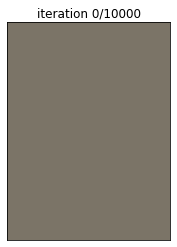

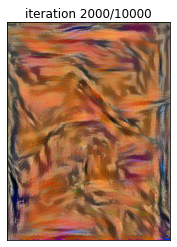

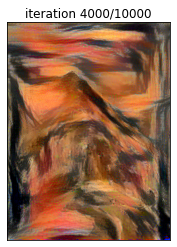

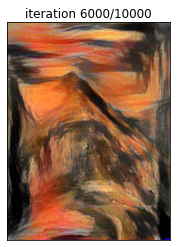

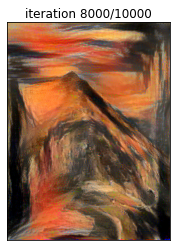

In [6]:
content_tensor = image_to_tensor(content_image)
style_tensor = image_to_tensor(style_image)

_, C, H, W = content_tensor.shape
g = torch.randn(C, H, W).mul(0.001).unsqueeze(0).requires_grad_(True)

transfer_style(model, optim.Adam([g], lr=1), content_tensor, style_tensor, 10_000, show_iterations=2_000);

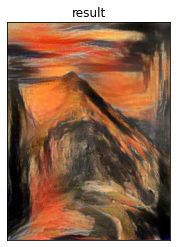

In [7]:
output_image = tensor_to_image(g.clone().detach())
cv2.imwrite('output/result.png', output_image.clip(0, 255))
show_image(output_image, 'result')